In [ ]:
import pandas as pd
df=pd.read_csv("Data Complete.csv")
df.sample(5)

,Unnamed: 0,Date,Open,Close,Adj Close,High,Low,Volume,MACD_Line,MACD_Signal,...,SMA_10,EMA_10,SMA_20,EMA_20,SMA_50,EMA_50,SMA_100,EMA_100,SMA_200,EMA_200
7327,7327,2025-03-06,1197.000000,1209.599976,1204.788208,1213.949951,1185.150024,14468014,-17.329317,-14.409278,...,1195.749280,1193.720112,1213.635352,1208.217375,1233.257483,1233.154904,1260.787535,1271.365986,1368.782479,1313.167096
3803,3803,2010-11-23,229.646088,227.577408,203.850479,229.726089,222.868607,33113827,-2.220053,0.435430,...,214.471970,212.067783,218.932471,215.093929,214.102802,213.965838,210.111070,212.197083,211.347465,210.628105
3935,3935,2011-06-03,219.554138,213.633835,193.127045,221.039932,212.925232,19110238,-1.512743,-2.490533,...,192.870799,193.897471,193.197286,194.521454,201.327687,198.078073,199.963563,201.065147,205.069411,203.947096
2437,2437,2005-05-13,38.452179,38.291515,32.967648,38.487881,38.130852,24848524,-0.005792,-0.113195,...,32.691891,32.754792,32.420334,32.705166,33.260970,32.768980,32.496389,32.465265,31.572395,31.623308
7302,7302,2025-01-30,1235.550049,1253.050049,1248.065430,1257.000000,1232.400024,9269259,-2.442084,-0.732659,...,1257.064417,1245.815302,1249.522028,1247.661447,1254.209807,1263.781330,1315.329949,1305.111691,1394.745693,1339.231819


In [14]:
df=df.drop(columns=['Unnamed: 0'])

# 5. Preparing Training & Testing Data for different cases

In [15]:
train_size=int(len(df)*0.8)

### ARIMA

In [16]:
train_arima=df['Adj Close'].iloc[:train_size]
test_arima=df['Adj Close'].iloc[train_size:]

print(type(train_arima),train_arima.shape)
print(type(test_arima),test_arima.shape)

<class 'pandas.core.series.Series'> (5973,)
<class 'pandas.core.series.Series'> (1494,)


### PROPHET

In [207]:
prophet_df=df.reset_index()[['Date','Adj Close']]
prophet_df.columns=["ds","y"]

train_prophet=prophet_df.iloc[:train_size]
test_prophet=prophet_df.iloc[train_size:]

### LSTM/GRU for multi-step

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [41]:
data_multi=scaler.fit_transform(df[['Adj Close']])

In [49]:
import numpy as np
def create_multistep_sequences(data,n_steps,k):
    x=[]
    y=[]
    for i in range(n_steps,len(data)-k+1):
        x.append(data[i-n_steps:i])    # past n days
        y.append(data[i:i+k])          # next k days
    return np.array(x),np.array(y)

n_steps=60
k=5
x,y=create_multistep_sequences(data_multi,n_steps,k)

x=x.reshape((x.shape[0],x.shape[1],1))
x_train_multistep,x_test_multistep=x[:train_size],x[train_size:]
y_train_multistep,y_test_multistep=y[:train_size],y[train_size:]

### XGBOOST/RANDOMFOREST for next day close price and direction

In [ ]:
next_day_df=df.drop(columns=['Date'])
next_day_df['Target']=next_day_df['Close'].shift(-1)
x_next_day=next_day_df.drop(columns=['Target'])
y_next_day=next_day_df['Target']

In [63]:
x_train_next_day,x_test_next_day=x_next_day[:train_size],x_next_day[train_size:]
y_train_next_day,y_test_next_day=y_next_day[:train_size],y_next_day[train_size:]





def prepare_xy(df, mode="regression", n_steps_in=60, n_steps_out=1):
    """
    mode: "regression", "classification", "arima", "prophet", "lstm"
    """
    if mode == "arima":
        return None, df["Close"]
    
    if mode == "prophet":
        prophet_df = df.reset_index()[["Date", "Close"]]
        prophet_df.columns = ["ds", "y"]
        return None, prophet_df
    
    if mode in ["regression", "classification"]:
        X = df[["Open", "High", "Low", "Close", "Volume", "MA_20", "MA_50", "Volatility"]]
        if mode == "regression":
            y = df["Close"].shift(-1)
        else:
            y = (df["Close"].shift(-1) > df["Close"]).astype(int)
        return X[:-1], y[:-1]
    
    if mode == "lstm":
        data = df["Close"].values
        X, y = [], []
        for i in range(len(data) - n_steps_in - n_steps_out):
            X.append(data[i:i+n_steps_in])
            y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out])
        return np.array(X), np.array(y)


from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

def train_model(X, y, mode="regression", model_type="xgb", n_steps_in=60, n_steps_out=1):
    if model_type == "arima":
        model = ARIMA(y, order=(5,1,0)).fit()
        return model
    
    if model_type == "prophet":
        model = Prophet()
        model.fit(y)  # here y is prophet_df
        return model
    
    if model_type in ["xgb", "rf"]:
        if mode == "regression":
            model = XGBRegressor() if model_type=="xgb" else RandomForestRegressor()
        else:
            model = XGBClassifier() if model_type=="xgb" else RandomForestClassifier()
        model.fit(X, y)
        return model
    
    if model_type in ["lstm", "gru"]:
        model = Sequential()
        if model_type == "lstm":
            model.add(LSTM(50, return_sequences=False, input_shape=(n_steps_in, 1)))
        else:
            model.add(GRU(50, return_sequences=False, input_shape=(n_steps_in, 1)))
        model.add(Dense(n_steps_out))
        model.compile(optimizer="adam", loss="mse")
        model.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, epochs=10, batch_size=32, verbose=1)
        return model

# 6. Model Training

## (i) ARIMA

In [197]:
import pmdarima as pm

train_arim=np.log(train_arima)
test_arim=np.log(test_arima)

model_arima=pm.auto_arima(train_arim,verbose=False)
forecast_arima=model_arima.predict(n_periods=len(test_arim))

forecast_arima=np.exp(forecast_arima)

root_mean_squared_error(test_arima,forecast_arima)

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

203.9169625963169

In [252]:
a=df['Date'].iloc[train_size:]
a=pd.to_datetime(a)

In [253]:
a.dtype

dtype('<M8[ns]')

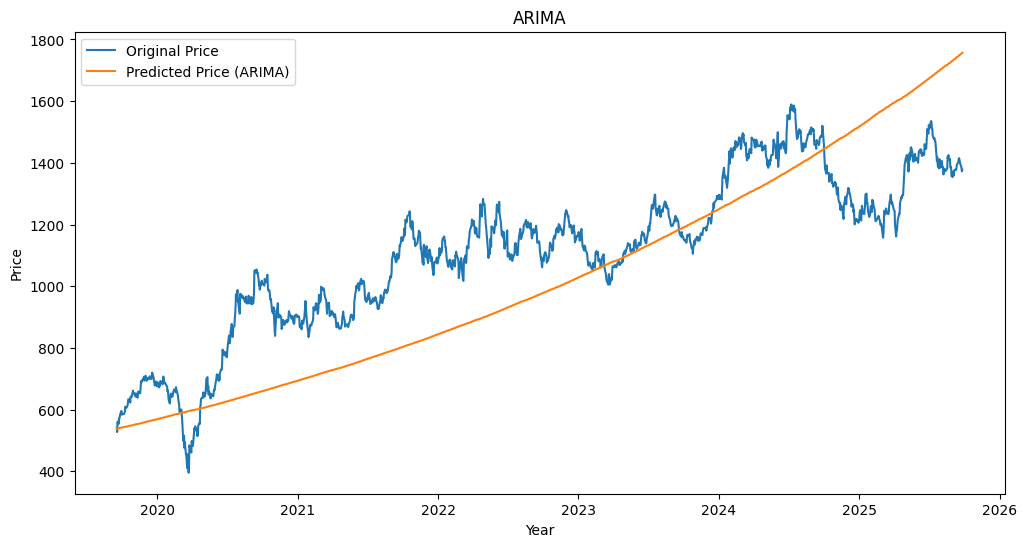

In [254]:
plt.figure(figsize=(12,6))
plt.title("ARIMA")
plt.xlabel("Year")
plt.ylabel("Price")
plt.plot(a,test_arima,label="Original Price")
plt.plot(a,forecast_arima,label='Predicted Price (ARIMA)')
plt.legend()

## (ii) PROPHET

In [208]:
from prophet import Prophet

train_prophet['y'],test_prophet['y']=np.log(train_prophet['y']),np.log(test_prophet['y'])

m=Prophet()
m.fit(train_prophet)

future_prophet=m.make_future_dataframe(periods=len(test_prophet))
forecast_prophet=m.predict(future_prophet)

/var/folders/nc/hvlqvddd2xj11jl0l69nx3580000gn/T/ipykernel_19660/2201988977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prophet['y'],test_prophet['y']=np.log(train_prophet['y']),np.log(test_prophet['y'])
16:02:30 - cmdstanpy - INFO - Chain [1] start processing
16:02:31 - cmdstanpy - INFO - Chain [1] done processing


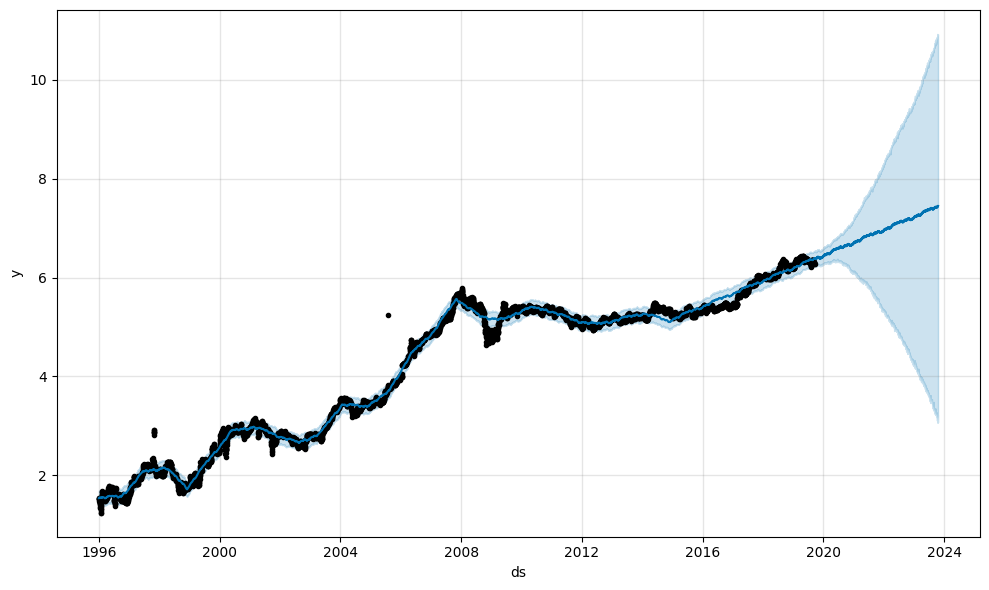

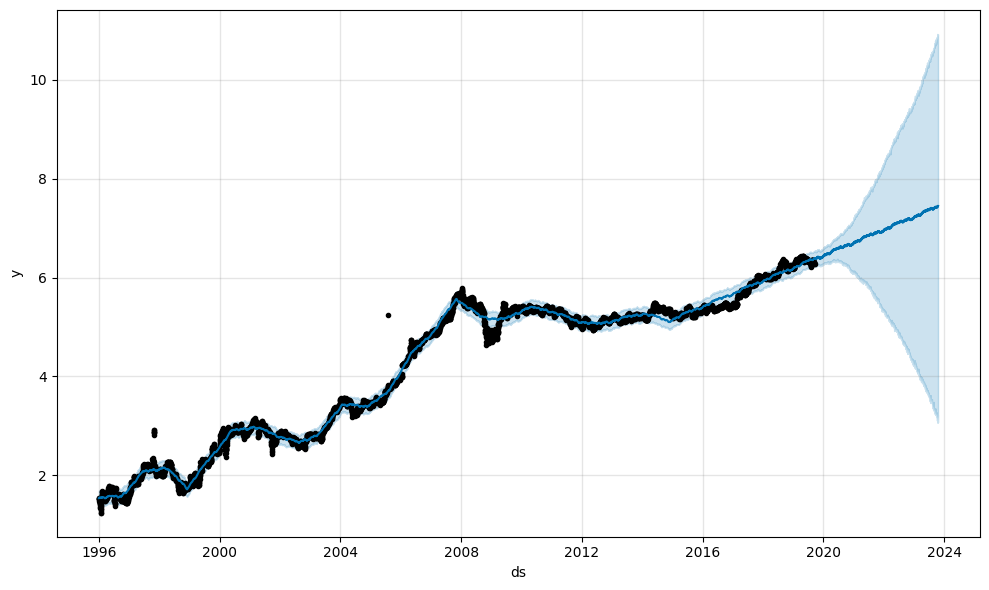

In [209]:
m.plot(forecast_prophet)

In [210]:
root_mean_squared_error(test_prophet['y'],forecast['yhat'].iloc[train_size:])

0.17215424061971918

In [211]:
test_prophet['y'],forecast['yhat'].iloc[train_size:]

(5973    6.290409
 5974    6.268057
 5975    6.329966
 5976    6.317814
 5977    6.349192
           ...   
 7462    7.237491
 7463    7.236915
 7464    7.232010
 7465    7.224316
 7466    7.228098
 Name: y, Length: 1494, dtype: float64,
 5973    6.392468
 5974    6.394112
 5975    6.391281
 5976    6.374350
 5977    6.374277
           ...   
 7462    7.446131
 7463    7.447897
 7464    7.451135
 7465    7.454214
 7466    7.452861
 Name: yhat, Length: 1494, dtype: float64)

In [212]:
np.exp(test_prophet['y']),np.exp(forecast['yhat'].iloc[train_size:])

(5973     539.373657
 5974     527.451721
 5975     561.137268
 5976     554.359985
 5977     572.030396
            ...     
 7462    1390.599976
 7463    1389.800049
 7464    1383.000000
 7465    1372.400024
 7466    1377.599976
 Name: y, Length: 1494, dtype: float64,
 5973     597.328952
 5974     598.311759
 5975     596.620131
 5976     586.603865
 5977     586.560903
            ...     
 7462    1713.221498
 7463    1716.249839
 7464    1721.816444
 7465    1727.125336
 7466    1724.791387
 Name: yhat, Length: 1494, dtype: float64)

In [213]:
test_proph=np.exp(test_prophet['y'])
predict_proph=np.exp(forecast['yhat'].iloc[train_size:])

In [214]:
root_mean_squared_error(test_proph,predict_proph)

180.35566068878805

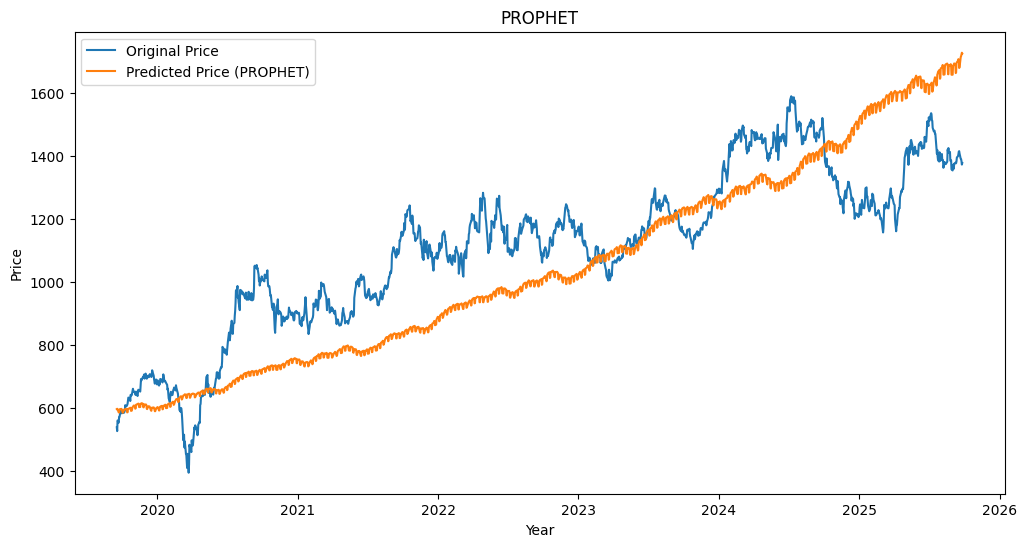

In [256]:
plt.figure(figsize=(12,6))
plt.title("PROPHET")
plt.xlabel("Year")
plt.ylabel("Price")
plt.plot(a,test_proph,label='Original Price')
plt.plot(a,predict_proph,label='Predicted Price (PROPHET)')
plt.legend()

## (iii) LSTM/GRU